In [37]:
#### 3.1.LMs with correlated errors: ARMD Trial application (Chapter 12) ####
# _____________________________________________________________________________
# LMs with fixed effects and correlated residual errors
# the assumption of independence typically does not hold in a 
# longitudinal study design, in which sampling units (subjects), are different
# from the units of analysis (visual acuity measurements).

In [38]:
library(nlmeU)  # --> for the dataset
library(nlme)   # --> for models implementation
library(lattice)
library(corrplot)
library(plot.matrix)

In [39]:
# our model formulation (from previous labs)
lm1.form <- formula(visual ~ -1 + visual0 + time.f + treat.f:time.f ) 

In [40]:
## We go back to the model fm9.2, where:
# varStruct <delta>-group i.e. lambda(delta,v)
# delta scalar, no strata 
# sigma_it = sigma * lambda_it 
#          = sigma * lambda(delta, TIME_it) 
#          = sigma * (TIME_it)^delta    
fm9.2 <- gls(lm1.form, weights = varPower(form = ~time), data = armd) 

# from the theory (Chapter 10)
# eps_i ~ N(0, sigma^2 R_i)
# where R_i = Lambda_i C_i Lambda_i 
# with Lambda_i is diagonal matrix with |TIME_it|^delta on diagonal, for t=1,2,3,4
# and C_i is correlation matrix (here, it's a 4x4 identity matrix)

# We now modify the model, so that the visual acuity measurements within individuals, 
# are allowed to be correlated.

In [65]:
# For choosing appropriate correlation structure, the empirical semivariogram can be useful.
?Variogram.gls
# We remind that Semivariogram is 1-h(d(t_ij, t_ij'),rho) and 
# h(d(t_ij, t_ij'),rho) is the correlation between two observations of the same group.

# NB. time differences for all possible six pairs of timepoints are different. 
# --> we can estimate the semivariogram to calculate correlation coefficients 
# between Pearson residuals for every pair of timepoints, separately.

# we start using time (time = 4,12,24,52)
(Vg1 <- Variogram(fm9.2, form = ~ time | subject))
# correlation between the residuals at 4 and 12 weeks is equal to 0.589 = 1−0.411
# correlation between the residuals at 12 and 24 weeks is equal to 0.643 = 1−0.357
# correlation between the residuals at 4 and 24 weeks is equal to 0.458 = 1−0.542
# correlation between the residuals at 24 and 52 weeks is equal to 0.762 = 1−0.238
# correlation between the residuals at 12 and 52 weeks is equal to 0.538 = 1−0.462
# correlation between the residuals at 4 and 52 weeks is equal to 0.386 = 1−0.614

,variog,dist,n.pairs
,<dbl>,<dbl>,<int[1d]>
1,0.4114380,8,224
2,0.3573865,12,214
3,0.5420185,20,212
4,0.2381944,28,190
5,0.4620258,40,194
6,0.6140054,48,193


Variogram.gls               package:nlme               R Documentation

_C_a_l_c_u_l_a_t_e _S_e_m_i-_v_a_r_i_o_g_r_a_m _f_o_r _R_e_s_i_d_u_a_l_s _f_r_o_m _a _g_l_s _O_b_j_e_c_t

_D_e_s_c_r_i_p_t_i_o_n:

     This method function calculates the semi-variogram for the
     residuals from a 'gls' fit. The semi-variogram values are
     calculated for pairs of residuals within the same group level, if
     a grouping factor is present. If 'collapse' is different from
     '"none"', the individual semi-variogram values are collapsed using
     either a robust estimator ('robust = TRUE') defined in Cressie
     (1993), or the average of the values within the same distance
     interval. The semi-variogram is useful for modeling the error term
     correlation structure.

_U_s_a_g_e:

     ## S3 method for class 'gls'
     Variogram(object, distance, form, resType, data,
           na.action, maxDist, length.out, collapse, nint, 

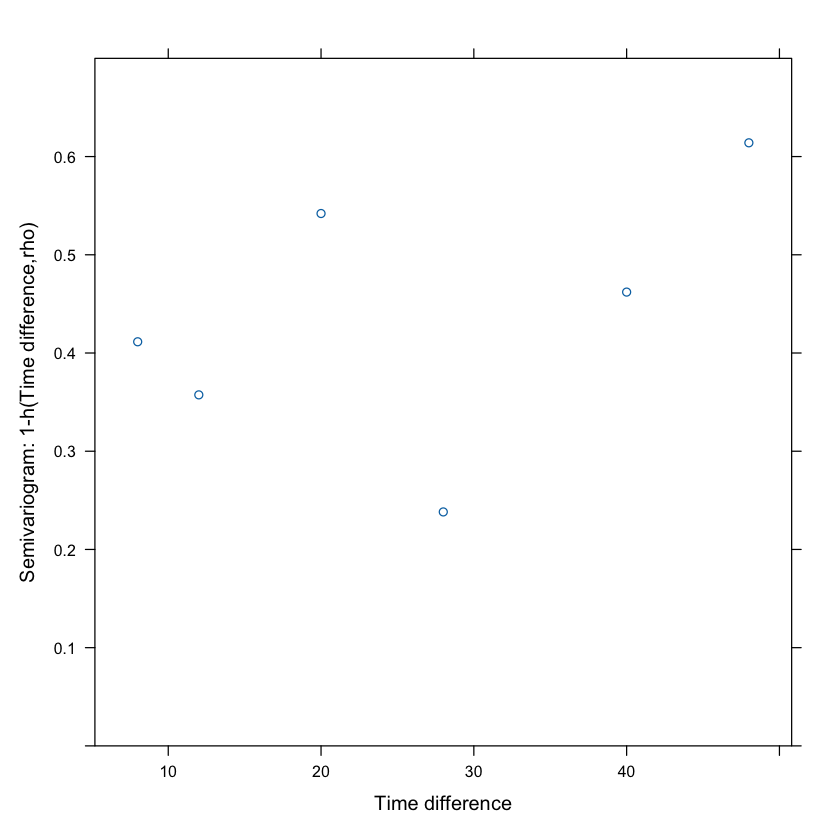

In [42]:
xlims <- c("4", "12","24","52wks")
ylims <- c(-4.9, 4.9)
plot(Vg1, smooth = FALSE, xlab = "Time difference", ylab = 'Semivariogram: 1-h(Time difference,rho)', ylim = c(0,0.7)) 

,variog,dist,n.pairs
,<dbl>,<dbl>,<int[1d]>
1,0.3406047,1,628
2,0.5037954,2,406
3,0.6140054,3,193


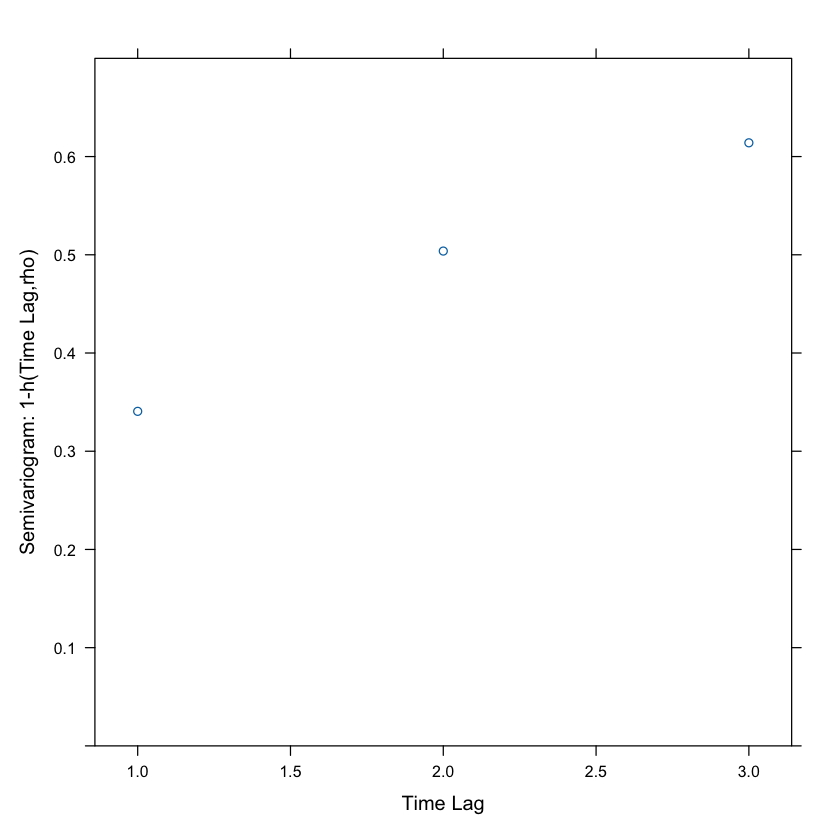

In [43]:
# now using time lag (tp = 1,2,3,4), i.e., the absolute difference between two position indexes
(Vg2 <- Variogram(fm9.2, form = ~ tp | subject))  # there are only 3 possible time lags
plot(Vg2, smooth = FALSE, xlab = "Time Lag", ylab = 'Semivariogram: 1-h(Time Lag,rho)', ylim = c(0,0.7))     
# we are using smooth=FALSE because there are few values       

# We notice that correlation decreases with the time difference/lag (because Semivariogram increases);
# --> a correlation structure like, e.g., a compound symmetry, will likely not fit the data well. 
# A more appropriate structure might be, e.g., an autoregressive process of order 1.

# For illustrative purposes, we consider a model with a compound symmetry correlation structure.

# NB. in the Variogram() function, we could also add robust=TRUE, which is an estimator
#     more robust in presence of outliers (see formula 10.39 and 10.40 book page 191)
#     by default, robust=FALSE

In [44]:
#### 1) Compound-Symmetry Correlation Structure - corCompSymm (Chapter 12.3) ####

# We assume:
# - Lambda_i is diagonal matrix with (TIME_it)^delta on diagonal, for t=1,2,3,4 (as before)
# - C_i (correlation matrix) has ones for diagonal terms (as before) and rho for extra-diagonal terms

fm12.1 <- gls(lm1.form, weights = varPower(form = ~time), 
              correlation = corCompSymm(form = ~1|subject),
              data = armd)

# we allow for a constant correlation of visual acuity measurements made at different
# timepoints for the same patient
summary(fm12.1)

Generalized least squares fit by REML
  Model: lm1.form 
  Data: armd 
      AIC      BIC   logLik
  6456.92 6513.975 -3216.46

Correlation Structure: Compound symmetry
 Formula: ~1 | subject 
 Parameter estimate(s):
      Rho 
0.5732584 
Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.2598167 

Coefficients:
                              Value Std.Error   t-value p-value
visual0                    0.922747 0.0368207 25.060552  0.0000
time.f4wks                 2.978881 2.1841555  1.363859  0.1730
time.f12wks                1.939807 2.2915716  0.846497  0.3975
time.f24wks               -1.775009 2.4031989 -0.738603  0.4604
time.f52wks               -6.981161 2.5808300 -2.705006  0.0070
time.f4wks:treat.fActive  -2.259712 1.1258703 -2.007080  0.0451
time.f12wks:treat.fActive -3.588143 1.5073004 -2.380510  0.0175
time.f24wks:treat.fActive -2.902815 1.8368847 -1.580292  0.1144
time.f52wks:treat.fActive -5.325264 2.3082963 -2.3

In [45]:
intervals(fm12.1, which = "var-cov")   # CIs for rho, delta, sigma 
# Comments:

# rho 
# the correlation coefficient rho (of any two visual acuity measurements
# obtained for the same patient) is equal to 0.573. 
# --> The 95% CI confirms the presence of a a non-negligible correlation 
#     between the visual acuity measurements. 

# sigma
# The scale parameter sigma is estimated to be equal to 5.98.

# delta (called power in R)
# The estimated power coefficient of the variance function, 0.260, is
# very close to the value of 0.252 obtained for model fm9.3 (varPower(form = ~time|treat.f) see lab2). 
# --> It indicates an increasing variability of the measurements over time.

Approximate 95% confidence intervals

 Correlation structure:
        lower      est.     upper
Rho 0.5043675 0.5732584 0.6367263

 Variance function:
          lower      est.    upper
power 0.2158154 0.2598167 0.303818

 Residual standard error:
   lower     est.    upper 
5.235422 5.981515 6.833934 

In [46]:
# With the estimates of rho, sigma and delta we can estimate the var-cov matrix (command: getVarCov)

# R_i computation (R_i is the marginal variance-covariance matrix of Y))
fm12.1vcov <- getVarCov(fm12.1, individual = "2")   # R_i, e.g. i=2
# individual="2" indicates that we request the matrix for subject "2", 
# for whom all four post-randomization measurements are available.
#fm12.1vcov

# we add names
nms <- c("4wks", "12wks", "24wks", "52wks")
dnms <- list(nms, nms)                              # Dimnames created
dimnames(fm12.1vcov) <- dnms                        # Dimnames assigned
print(fm12.1vcov)

fm12.1vcov

Marginal variance covariance matrix
        4wks   12wks   24wks   52wks
4wks  73.531  56.077  67.143  82.081
12wks 56.077 130.140  89.323 109.200
24wks 67.143  89.323 186.560 130.740
52wks 82.081 109.200 130.740 278.810
  Standard Deviations: 8.575 11.408 13.659 16.698 


Marginal variance covariance matrix
        4wks   12wks   24wks   52wks
4wks  73.531  56.077  67.143  82.081
12wks 56.077 130.140  89.323 109.200
24wks 67.143  89.323 186.560 130.740
52wks 82.081 109.200 130.740 278.810
  Standard Deviations: 8.575 11.408 13.659 16.698 

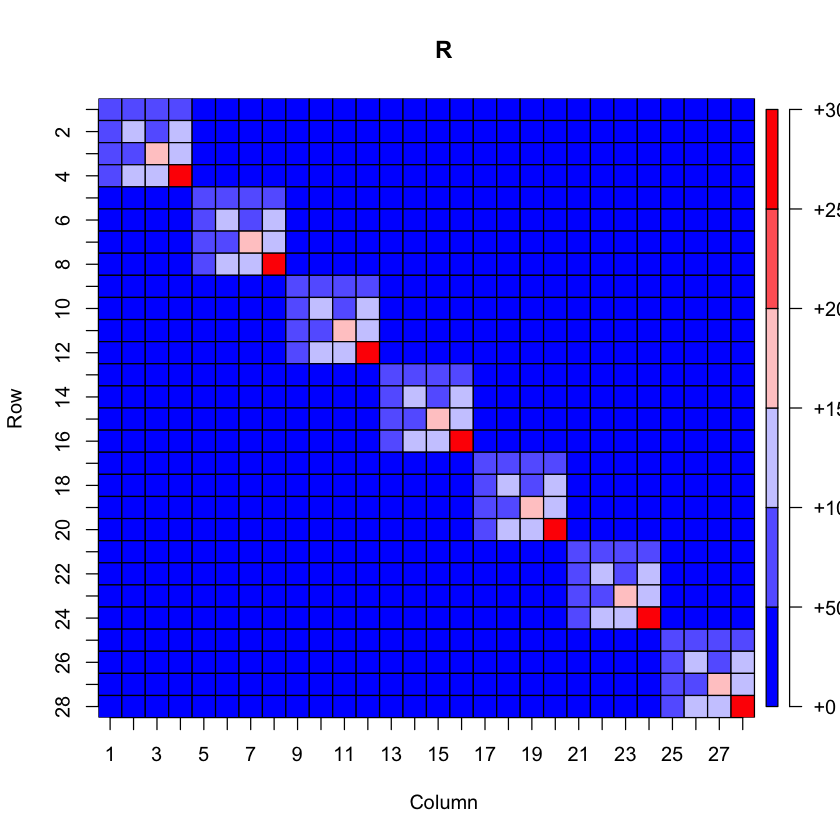

In [47]:
# Visualization of R_i
R_i = fm12.1vcov
R = matrix(0, nrow=28, ncol=28) # example for 7 subjects with all the observations
for(i in 0:6){
  R[(i*4+1):(i*4+4),(i*4+1):(i*4+4)] = R_i
}
par(bg = 'white')
plot(R, col=colorRampPalette(c("blue", "white", "red")))

Marginal correlation matrix
         4wks   12wks   24wks   52wks
4wks  1.00000 0.57326 0.57326 0.57326
12wks 0.57326 1.00000 0.57326 0.57326
24wks 0.57326 0.57326 1.00000 0.57326
52wks 0.57326 0.57326 0.57326 1.00000


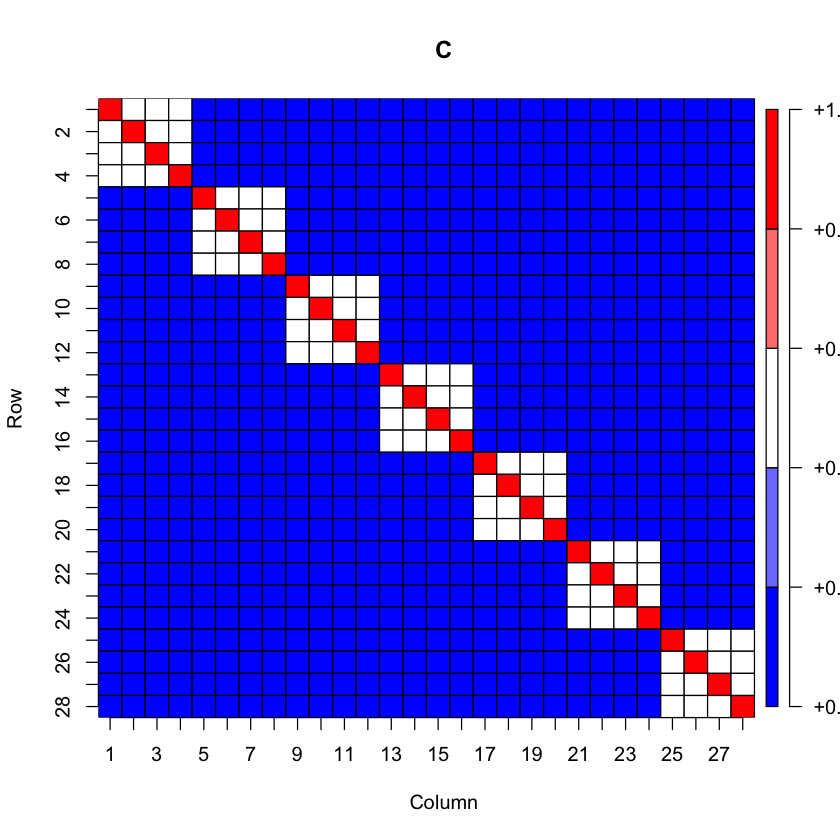

In [48]:
# C_i computation
# we get correlation structure through cov2cor --> it is actually following corCompSymm structure
print(cov2cor(fm12.1vcov),           # C_i
      corr = TRUE, stdevs = FALSE) 
# corr = TRUE chooses the form of the printout, suitable for correlation matrix;
# stdevs = FALSE because standard deviations are irrelevant for a correlation matrix (and so we don't display them).

# Visualization of C_i
C = matrix(0, nrow=28, ncol=28) # example for 7 subjects with all the observations
for(i in 0:6){
  C[(i*4+1):(i*4+4),(i*4+1):(i*4+4)] = cov2cor(fm12.1vcov)
}
plot(C, col=colorRampPalette(c("blue", "white", "red")))

In [49]:
# test based on the restricted likelihoods, 
# because we use it for a comparison of models with the same mean structures
anova(fm9.2, fm12.1) 
# pval < 0.0001 --> there is enough proof against the assumption H0 
# --> data provide evidence for assuming a constant correlation of visual acuity measurements 
#     made at different timepoints for the same patient


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm9.2,"gls(model = lm1.form, data = armd, weights = varPower(form = ~time))",1,11,6738.126,6790.427,-3358.063,,NA,NA
fm12.1,"gls(model = lm1.form, data = armd, correlation = corCompSymm(form = ~1 | subject), weights = varPower(form = ~time))",2,12,6456.920,6513.975,-3216.460,1 vs 2,283.2067,1.502521e-63


In [50]:
#### 2) Heteroscedastic Autoregressive Residual Errors - corAR1 (Chapter 12.4) ####

# We assume:
# - Lambda_i is diagonal matrix with (TIME_it)^delta on diagonal, for t=1,2,3,4 (as before)
# - C_i (correlation matrix) has ones for diagonal terms (as before) and rho^k for extra-diagonal terms
#   where k is the time unit between two different measurements (armd$tp)
#   and rho is the correlation between two adjacent measurements
# NB. it means that correlation decreases for measurements obtained at more distant timepoints

fm12.2 <- update(fm9.2,                                     # fm12.2 nested in fm9.2
                correlation = corAR1(form = ~tp|subject),  # NB: remember that form = ~1 | subject) would lead to a mistake
                data = armd)
summary(fm12.2)

Generalized least squares fit by REML
  Model: lm1.form 
  Data: armd 
       AIC      BIC    logLik
  6396.911 6453.966 -3186.455

Correlation Structure: ARMA(1,0)
 Formula: ~tp | subject 
 Parameter estimate(s):
     Phi1 
0.6573069 
Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.2311874 

Coefficients:
                              Value Std.Error   t-value p-value
visual0                    0.882255 0.0373833 23.600255  0.0000
time.f4wks                 5.225502 2.2192976  2.354575  0.0188
time.f12wks                4.173269 2.3145900  1.803027  0.0717
time.f24wks                0.506153 2.4080635  0.210191  0.8336
time.f52wks               -4.848195 2.5648488 -1.890246  0.0591
time.f4wks:treat.fActive  -2.277328 1.1497227 -1.980763  0.0479
time.f12wks:treat.fActive -3.601515 1.4894624 -2.417996  0.0158
time.f24wks:treat.fActive -3.125211 1.7817577 -1.754005  0.0798
time.f52wks:treat.fActive -4.744491 2.2102239 -2.1466

In [51]:
intervals(fm12.2, which = "var-cov") # CIs for rho, delta, sigma

Approximate 95% confidence intervals

 Correlation structure:
         lower      est.     upper
Phi1 0.6039862 0.6573069 0.7047698

 Variance function:
          lower      est.    upper
power 0.1831427 0.2311874 0.279232

 Residual standard error:
   lower     est.    upper 
5.502862 6.356295 7.342086 

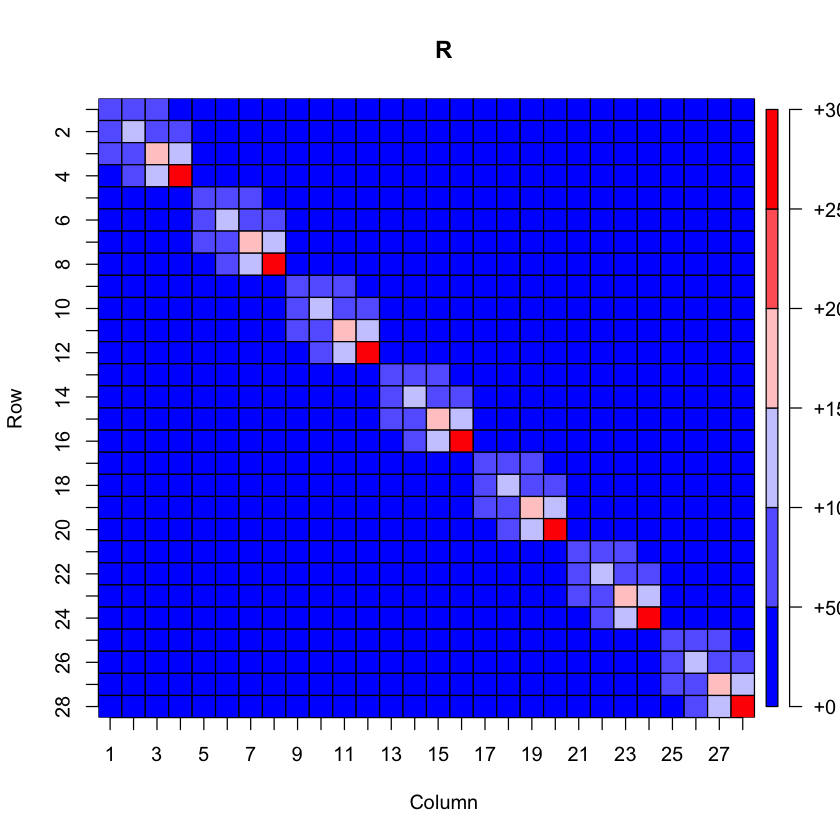

In [52]:
# R_i computation
fm12.2vcov <- getVarCov(fm12.2, individual = "2")
dimnames(fm12.2vcov) <- dnms
R_i = fm12.2vcov                    # R_i matrix 

# Visualization of R_i
R = matrix(0, nrow=28, ncol=28) # example for 7 subjects with all the observations
for(i in 0:6){
  R[(i*4+1):(i*4+4),(i*4+1):(i*4+4)] = R_i
}
par(bg = 'white')
plot(R, col=colorRampPalette(c("blue", "white", "red")))

Marginal correlation matrix
      4wks 12wks 24wks 52wks
4wks  1.00  0.66  0.43  0.28
12wks 0.66  1.00  0.66  0.43
24wks 0.43  0.66  1.00  0.66
52wks 0.28  0.43  0.66  1.00


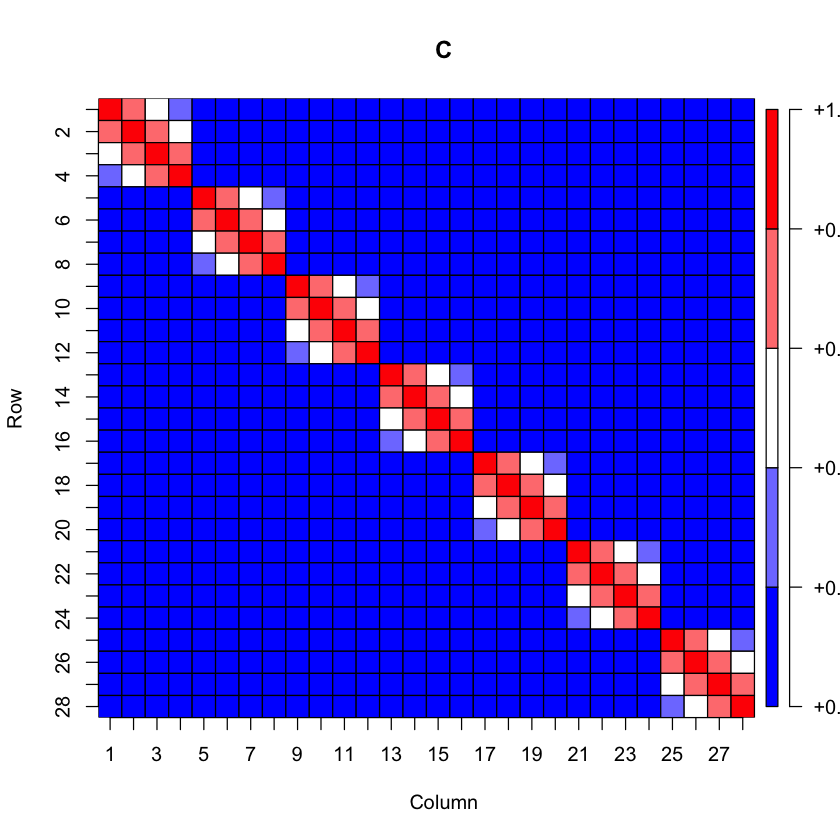

In [53]:
# C_i computation
# we get correlation structure through cov2cor
fm12.2cor <- cov2cor(fm12.2vcov)
print(fm12.2cor, digits = 2,         # C_i
      corr = TRUE, stdevs = FALSE) 

# Visualization of C_i
C = matrix(0, nrow=28, ncol=28) # example for 7 subjects with all the observations
for(i in 0:6){
  C[(i*4+1):(i*4+4),(i*4+1):(i*4+4)] = fm12.2cor
}
par(bg = 'white')
plot(C, col=colorRampPalette(c("blue", "white", "red")))

In [54]:
# correlation coefficient for the visual acuity measurements adjacent in time 
# (e.g., those at weeks 4 and 12, or at weeks 12 and 24, etc.) is equal to rho = 0.66
# --> it's higher than 0.57 obtained for the compound-symmetry structure.

# On the other hand, the measurements separated by one intermittent observation
# (e.g., those at weeks 4 and 24), are correlated with the correlation coefficient equal
# to rho^2 = 0.43, which is lower than 0.57.

# Compound-symmetry vs. autoregressive correlation (non-nested models)
anova(fm12.1, fm12.2) # We look at the AIC because the models are non-nested and LR test cannot be performed

# we prefer AR(1):
# the model with the autoregressive correlation structure provides a better description 
# of the data, in line with the results of the exploratory analysis and 
# of the considerations based on the empirical semivariogram

# Although the autoregressive correlation structure allows for differences in the
# values of correlation coefficients, it assumes a particular form of these differences (see C_i). 
# This assumption could be incorrect --> we consider a fully general correlation structure, 
# which does not impose any constraints on the possible differences.

,call,Model,df,AIC,BIC,logLik
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
fm12.1,"gls(model = lm1.form, data = armd, correlation = corCompSymm(form = ~1 | subject), weights = varPower(form = ~time))",1,12,6456.920,6513.975,-3216.460
fm12.2,"gls(model = lm1.form, data = armd, correlation = corAR1(form = ~tp | subject), weights = varPower(form = ~time))",2,12,6396.911,6453.966,-3186.455


Generalized least squares fit by REML
  Model: lm1.form 
  Data: armd 
     AIC      BIC  logLik
  6387.2 6468.028 -3176.6

Correlation Structure: General
 Formula: ~tp | subject 
 Parameter estimate(s):
 Correlation: 
  1     2     3    
2 0.582            
3 0.448 0.651      
4 0.301 0.531 0.766
Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.2712623 

Coefficients:
                              Value Std.Error   t-value p-value
visual0                    0.891363 0.0361599 24.650578  0.0000
time.f4wks                 4.730799 2.1428592  2.207704  0.0275
time.f12wks                3.673201 2.2529184  1.630419  0.1034
time.f24wks                0.002330 2.3670507  0.000984  0.9992
time.f52wks               -5.332269 2.5553125 -2.086739  0.0372
time.f4wks:treat.fActive  -2.290808 1.0977631 -2.086796  0.0372
time.f12wks:treat.fActive -3.602429 1.4872237 -2.422251  0.0156
time.f24wks:treat.fActive -3.127501 1.8246640 -1.71401

Approximate 95% confidence intervals

 Correlation structure:
             lower      est.     upper
cor(1,2) 0.4896548 0.5820562 0.6615290
cor(1,3) 0.3323642 0.4481962 0.5507087
cor(1,4) 0.1520140 0.3006207 0.4359361
cor(2,3) 0.5713879 0.6512193 0.7188421
cor(2,4) 0.4196516 0.5309614 0.6265384
cor(3,4) 0.6986288 0.7657788 0.8195562

 Variance function:
          lower      est.     upper
power 0.2191548 0.2712623 0.3233698

 Residual standard error:
   lower     est.    upper 
4.954312 5.737923 6.645476 

Marginal variance covariance matrix
        4wks   12wks   24wks   52wks
4wks  69.846  54.769  50.897  42.105
12wks 54.769 126.760  99.627 100.180
24wks 50.897  99.627 184.630 174.380
52wks 42.105 100.180 174.380 280.860
  Standard Deviations: 8.3574 11.259 13.588 16.759 
Marginal correlation matrix
         4wks   12wks   24wks   52wks
4wks  1.00000 0.58206 0.44820 0.30062
12wks 0.58206 1.00000 0.65122 0.53096
24wks 0.44820 0.65122 1.00000 0.76578
52wks 0.30062 0.53096 0.76578 1.00000


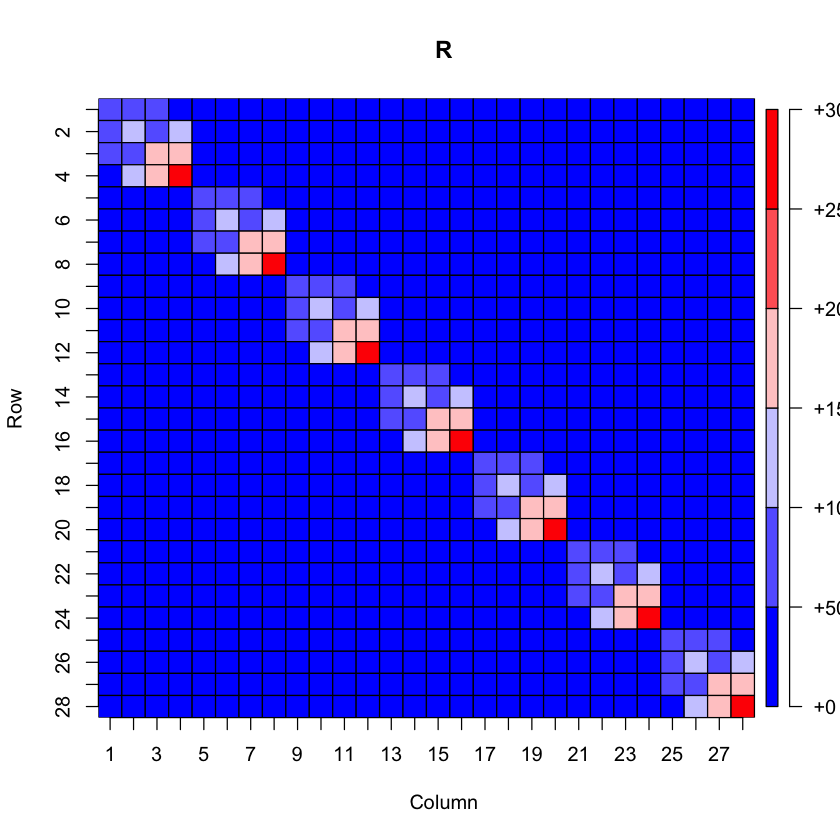

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm12.2,"gls(model = lm1.form, data = armd, correlation = corAR1(form = ~tp | subject), weights = varPower(form = ~time))",1,12,6396.911,6453.966,-3186.455,,NA,NA
fm12.3,"gls(model = lm1.form, data = armd, correlation = corSymm(form = ~tp | subject), weights = varPower(form = ~time))",2,17,6387.200,6468.028,-3176.600,1 vs 2,19.71104,0.001415742


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm12.3,"gls(model = lm1.form, data = armd, correlation = corSymm(form = ~tp | subject), weights = varPower(form = ~time))",1,17,6387.200,6468.028,-3176.600,,NA,NA
fm12.3.b,"gls(model = lm1.form, data = armd, correlation = corSymm(form = ~tp | subject), weights = varIdent(form = ~1 | time.f))",2,19,6389.356,6479.694,-3175.678,1 vs 2,1.843159,0.3978901


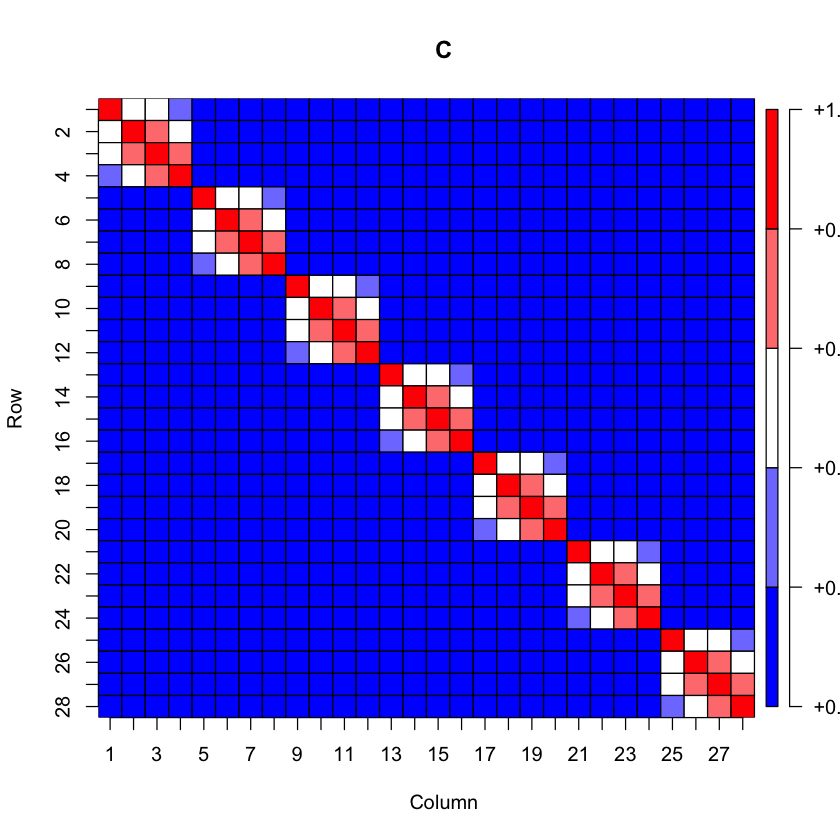

In [55]:
#### 3) General correlation matrix for Residual Errors - corSymm (Chapter 12.5) ####

# We assume:
# - Lambda_i is diagonal matrix with (TIME_it)^delta on diagonal, for t=1,2,3,4 (as before)
# - C_i (correlation matrix) has ones for diagonal terms (as before) and rho_j,j' for extra-diagonal terms
#   where j,j' are two different time units (armd$tp)
#   and rho is the correlation between two adjacent measurements

fm12.3 <- update(fm12.2, correlation = corSymm(form = ~tp|subject), data = armd)
summary(fm12.3)
intervals(fm12.3, which = "var-cov")              # 95% CIs for rho, delta, sigma
          
# R_i computation
fm12.3vcov <- getVarCov(fm12.3, individual = "2") # R_i  
dimnames(fm12.3vcov) <- dnms
print(fm12.3vcov)
R_i = fm12.3vcov                                  # R_i matrix 

# Visualization of R_i
R = matrix(0, nrow=28, ncol=28) # example for 7 subjects with all the observations
for(i in 0:6){
  R[(i*4+1):(i*4+4),(i*4+1):(i*4+4)] = R_i
}
plot(R, col=colorRampPalette(c("blue", "white", "red")))


# C_i computation
# we get correlation structure through cov2cor
fm12.3cor <- cov2cor(fm12.3vcov)                  # C_i
print(fm12.3cor, corr = TRUE, stdevs = FALSE)
# the correlation decreases for visual acuity measurements more distant in time

# Visualization of C_i
C = matrix(0, nrow=28, ncol=28) # example for 7 subjects with all the observations
for(i in 0:6){
  C[(i*4+1):(i*4+4),(i*4+1):(i*4+4)] = fm12.3cor
}
plot(C, col=colorRampPalette(c("blue", "white", "red")))



anova(fm12.2, fm12.3)              # M12.2 nested in M12.3
# --> we can conclude at 5% that model fm12.3 provides a better fit than model fm12.2


In [66]:
# We now check whether a model 
# --> with the general correlation structure (corSymm), 
# --> and the most general variance function (varIdent), which
# allows arbitrary (positive) variances of the visual acuity measurements made at
# different timepoints, 
# could offer a better fit than model fm12.3

fm12.3.b <- update(fm12.3, weights = varIdent(form = ~1|time.f))      # Alternative model
anova(fm12.3, fm12.3.b)              # M12.3 nested in fm12.3.b model
# from p-value + AIC, we deduce that
# --> the simpler model fm12.3 provides an adequate summary of the data.

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm12.3,"gls(model = lm1.form, data = armd, correlation = corSymm(form = ~tp | subject), weights = varPower(form = ~time))",1,17,6387.200,6468.028,-3176.600,,NA,NA
fm12.3.b,"gls(model = lm1.form, data = armd, correlation = corSymm(form = ~tp | subject), weights = varIdent(form = ~1 | time.f))",2,19,6389.356,6479.694,-3175.678,1 vs 2,1.843159,0.3978901


In [56]:
#### Model-Fit Diagnostics ####
# we analyze model fm12.3

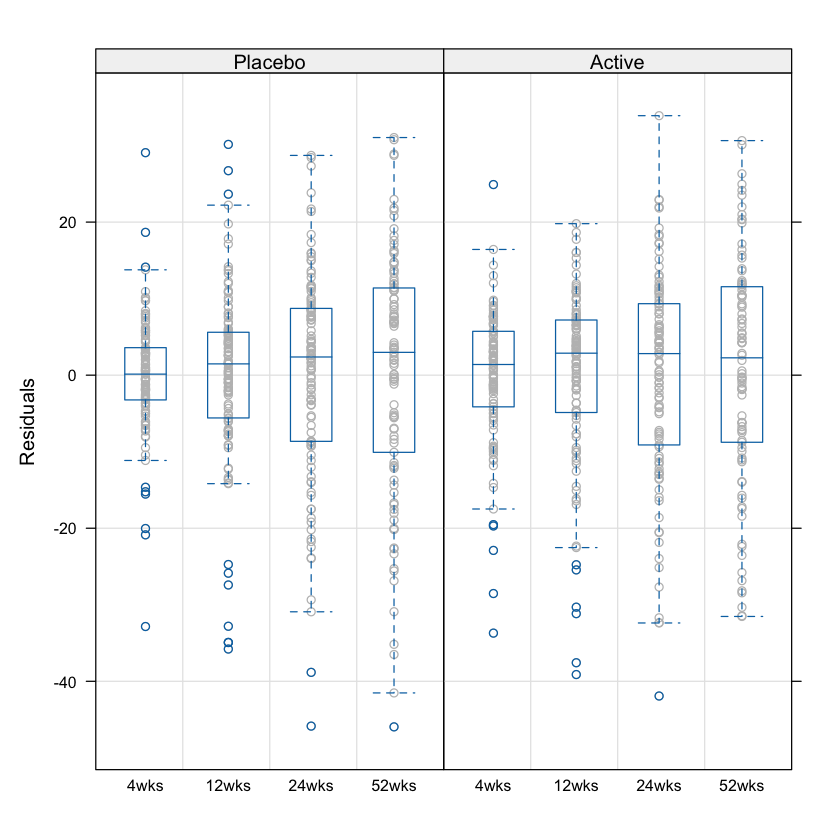

In [57]:
##### (a) Plots (and boxplots) of raw residuals ##### 
# we combine one-dimensional scatterplot (stripplot) with a box-and-whiskers plot
# and we add a grid of horizontal lines aligned with the axis labels
panel.bwxplot0 <- function(x,y, subscripts, ...){
  panel.grid(h = -1)
  panel.stripplot(x, y, col = "grey", ...)
  panel.bwplot(x, y, pch = "|", ...)
}

bwplot(resid(fm12.3) ~ time.f | treat.f, 
       panel = panel.bwxplot0,
       ylab = "Residuals", data = armd)
# --> increasing variance of the residuals with timepoint. 
# This reflects the heteroscedasticity.

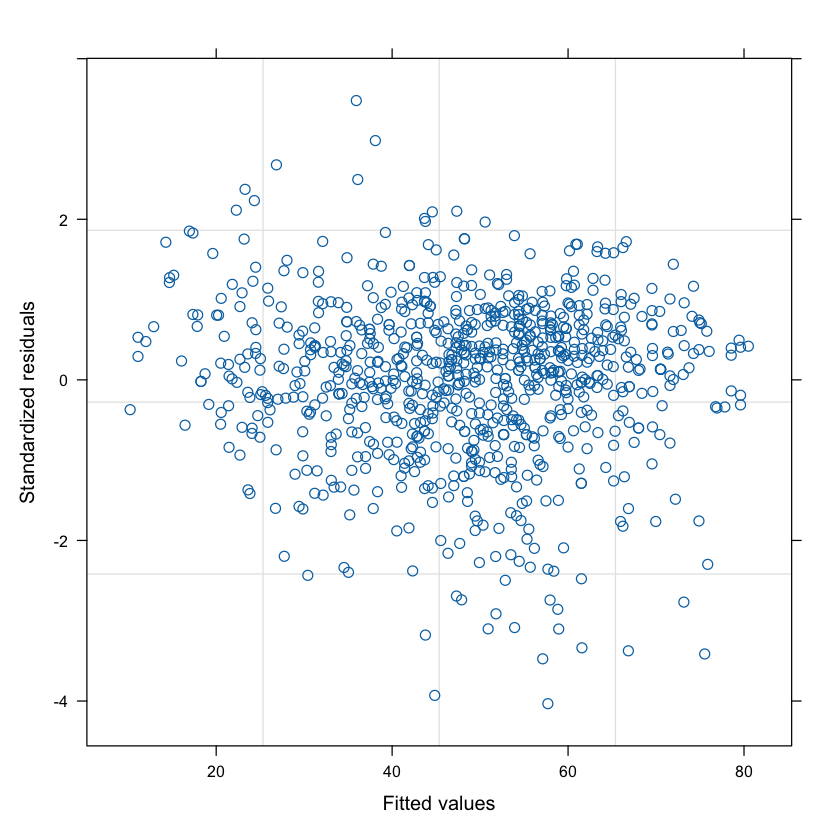

In [67]:
##### (b) Plots of Pearson residuals vs. fitted values ##### 

plot(fm12.3) # default scatterplot of Pearson residuals versus the fitted values

# here the residuals for different timepoints are plotted together
# --> due to the correlation of the residuals corresponding to the measurements 
#     for the same patient at different timepoints, the plot reveals a pattern, with a few
#     large, positive residuals in the upper-left part and a few negative ones in the lower-right part.

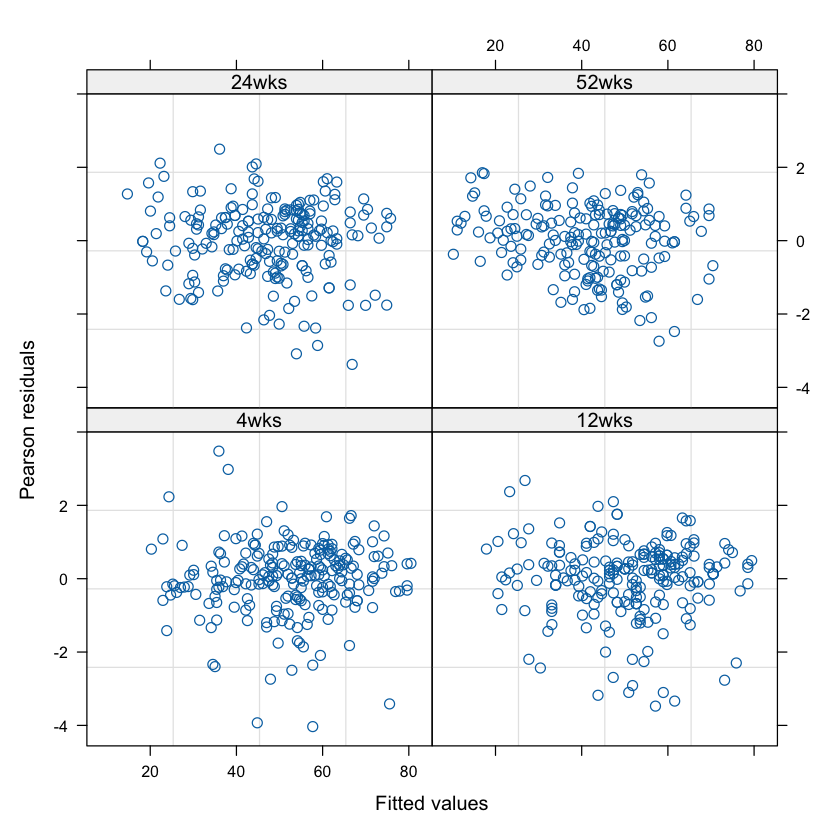

In [68]:
# --> we decide to visualize the residuals for each time instants
plot(fm12.3, resid(., type = "p") ~ fitted(.) | time.f, ylab = 'Pearson residuals') # type='p' stands for Pearson residuals
# more balanced pattern


# the main issue in the interpretation of Pearson residuals is the fact that they are Correlated: look at this plot

[1] 10

[1] 10

[1] 75  82  100 114 122 132 136 148 227 231
234 Levels: 1 2 3 4 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 ... 240

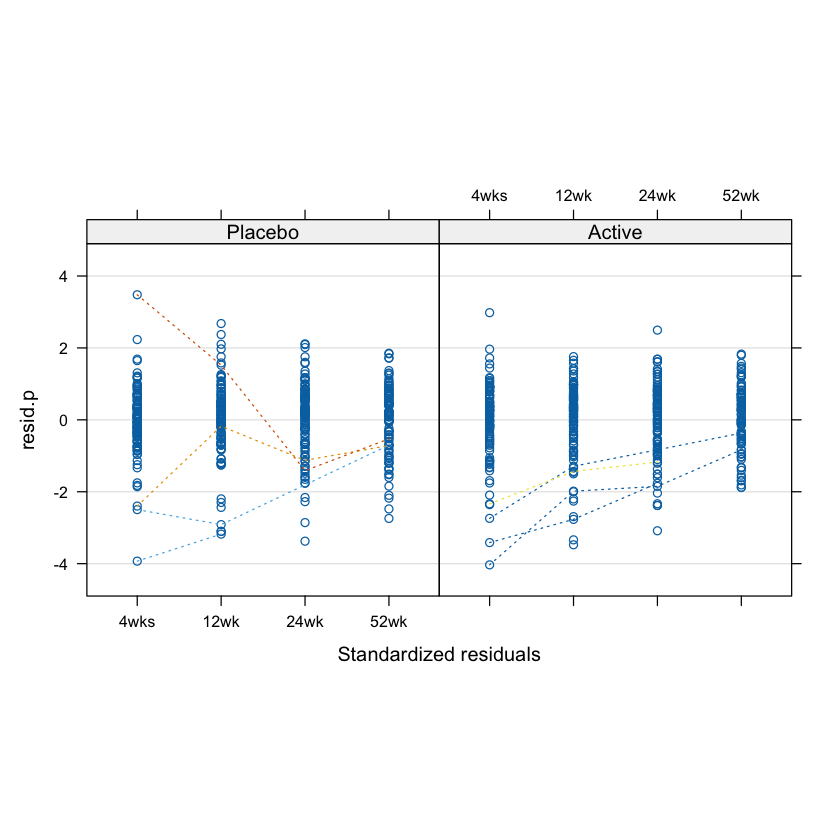

In [69]:
#___ plot starts
# connecting lines for outlying subjects at time = 4
idq <- 0.02               
id <- armd$subject
residP <- resid(fm12.3, type = "pearson")  # Pearson residuals
attach(armd)
idx1 <- tp == 1                                    # time = 4 wks 
idx <- (abs(residP) > -qnorm(idq/2)) & idx1        # Logical vector
outliers.idx <- data.frame(subject, time, treat.f, visual, residP, idx)
outliers <- subset(outliers.idx, idx, select = -idx)
nrow(outliers)                                     # Number of outliers
uid <- unique(outliers$subject)
length(uid)                                        # Number of selected subjects
uid
detach(armd)

gin <-  rep(FALSE, length(armd$subject))
gin[id %in% uid] <- TRUE

dt <- data.frame(armd, gin=gin, resid.p = residP)
dtGin <- dt[gin, ]

myPanel <- function(x, y, subscripts, groups, ...) {
  panel.grid(h = -1, v = 0) 
  gin <- dt$gin
  gins <- gin[subscripts]
  panel.xyplot(x, y)   # All points
  x1 <- x[gins]
  y1 <- y[gins]
  subs1 <- subscripts[gins]
  panel.superpose(x1, y1, subs1, groups, type = "l", lty = "13")
}

xyplot(resid.p ~ time.f | treat.f, data = dt,
       panel = myPanel,
       subscripts = TRUE,
       groups = subject,
       scales = list(abbreviate = TRUE),
       aspect = 1,
       xlab = "Standardized residuals",
       ylim = ylims)
#___ plot ends

# The residuals obtained for most of the selected individuals 
# tend to always have negative values
# --> we move to normalized residuals

[1] -4.032895  3.478536

[1] "=0.58"
[1] "=0.42"
[1] "=0.65"
[1] "=0.27"
[1] "=0.5"
[1] "=0.74"
[1] "P4wks"  "P12wks" "P24wks" "P52wks"

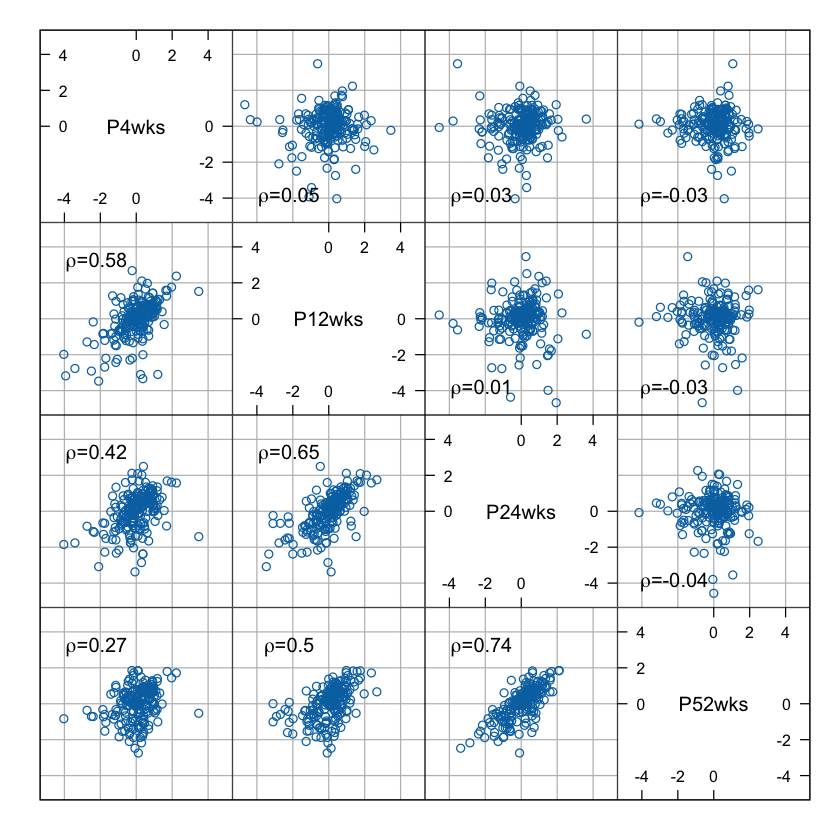

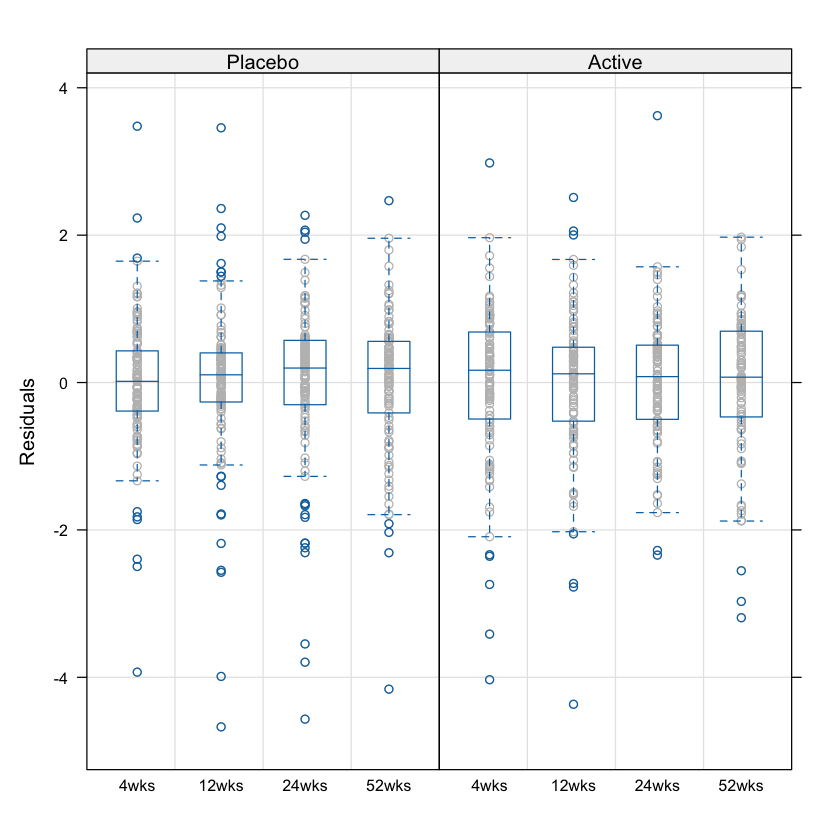

In [70]:
##### (c) Plots of normalized residuals ##### 
# To remove the correlation between Pearson residuals, we use the Normalized residuals:
# we plot scatterplots of Pearson residuals (below the diagonal)
# and the normalized residuals (above the diagonal) for all pairs of timepoints for fm12.3.

#______ plot starts
r1p <- resid(fm12.3, type = "pearson")
r1n <- resid(fm12.3, type = "normalized")
dtP <- data.frame(armd, r1p, r1n)
library(reshape)
dtPm <- melt(dtP,
             measure.var = c("r1p","r1n"),
             id.var = c("subject","time.f"))
dtPc <- cast(dtPm, subject*variable ~ time.f) #
dtPc <- data.frame(dtPc) 
names(dtPc) <- c("subject","var","P4wks","P12wks","P24wks","P52wks")
range(dtPc$P4wks, na.rm = TRUE)  

myFunL <- function(corx) { 
  ltext(-2.2, 3.2, substitute(paste(rho, corx), list(corx = corx)), cex = 1)
}

myFunU <- function(corx) { 
  ltext(-2.2,-3.9, substitute(paste(rho,corx),list(corx = corx)), cex = 1)
}

my.upperPanel <-   ## pairwise.complete.obs 
  function(x, y, subscripts, ...){
    vr <- dtPc$var == "r1n" 
    subs <- subscripts[vr]         
    x1 <- x[subs]
    y1 <- y[subs]
    panel.abline(h = c(-4, -2, 0, 2, 4), col = "grey", ...)
    panel.abline(v = c(-4, -2, 0, 2, 4), col = "grey", ...)
    panel.xyplot(x1, y1, ...)
    corx <- round(cor(x1, y1, use = "complete.obs"), 2)
    abs.corx <- abs(corx)
    corx <- paste("=", corx, sep = "")
    myFunU(corx)
  }

my.lowerPanel <-    ## pairwise.complete.obs 
  function(x, y, subscripts, ...){
    vr <- dtPc$var == "r1p" 
    subs <- subscripts[vr]         
    x1 <- x[subs]
    y1 <- y[subs]
    panel.abline(h = c(-4, -2, 0, 2, 4), col = "grey", ...)
    panel.abline(v = c(-4, -2, 0, 2, 4), col = "grey", ...)
    panel.xyplot(x1, y1, ...)
    corx <- round(cor(x1, y1, use = "complete.obs"), 2)
    abs.corx <- abs(corx)
    corx <- paste("=", corx, sep = "")
    print(corx)
    cex.value <- 2
    myFunL(corx)
  }

mySuperPanel <- function(z, subscripts, panel.subscripts, ...){
  panel.pairs(z, subscripts = subscripts,
              panel.subscripts = panel.subscripts,
              as.matrix = TRUE, 
              upper.panel = "my.upperPanel",
              lower.panel = "my.lowerPanel",
              ## simpler syntax: prepanel.limits = function(z) return(c(-4.7,4.7))
              pscales =list(
                P4wks =list(limits=c(-4.7,4.7)),
                P12wks=list(limits=c(-4.7,4.7)),
                P24wks=list(limits=c(-4.7,4.7)),
                P52wks=list(limits=c(-4.7,4.7))  ) )
  print(names(z))
}

abbrev.names <- c("vis0", "vis4", "vis12", "vis24", "vis52")
splom.form <- formula(~cbind(P4wks,P12wks,P24wks,P52wks))
splom(splom.form,
      data = dtPc,   #### subset(armd240,miss.pat =="----"),   
      as.matrix = TRUE,  #### varnames = abbrev.names, 
      xlab = "",
      superpanel = mySuperPanel 
)
#______ plot ends

# The scatterplots of Pearson residuals show a correlation between the
# residuals corresponding to different timepoints. On the other hand, the plots for
# the normalized residuals clearly illustrate that the residuals are (approximately)
# uncorrelated.

# same as before, but with normalized residuals
bwplot(resid(fm12.3, type = 'n') ~ time.f | treat.f, 
       panel = panel.bwxplot0,
       ylab = "Residuals", data = armd)
# a few more extreme residuals with negative values, smaller than −4. Nevertheless, the number of
# residuals with an absolute value larger than, e.g., 2 is about the same.


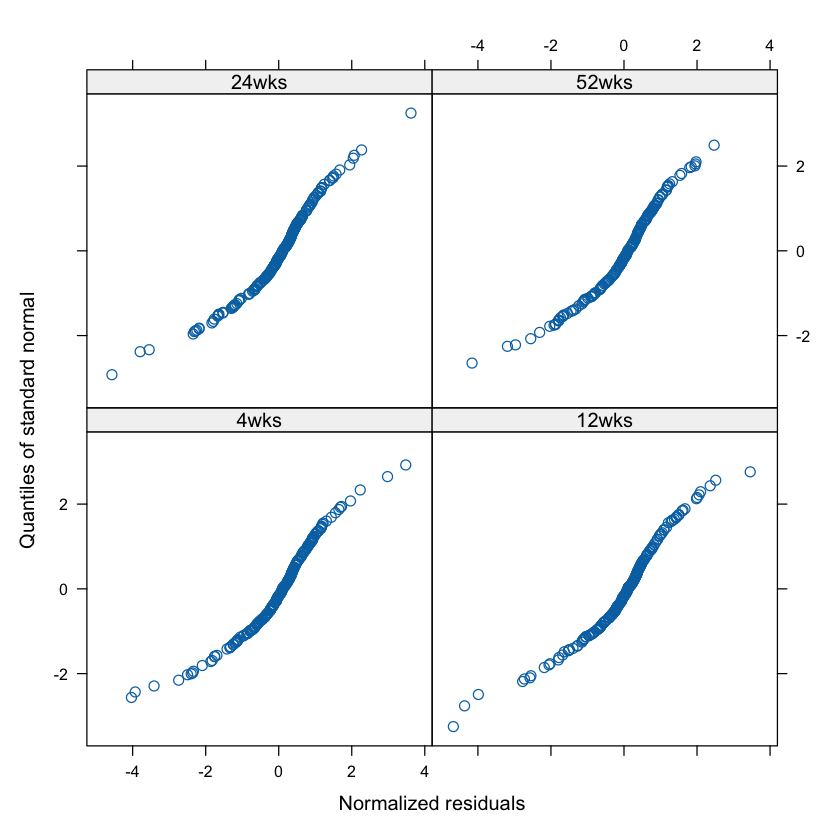

In [60]:
##### (d) normality assumption ##### 
qqnorm(fm12.3, ~resid(., type= "n") | time.f) # we require the plot of normalized residuals
# Although normalized residuals should be approximately uncorrelated, 
# we graph separate Q-Q plots per timepoint to remove the influence of
# any residual correlation.
# The patterns appear to be reasonably close to straight lines. 
# --> the normality assumption seems to be plausible for the ARMD data.

#### Tests of hypotheses about the fixed effects ####


In [61]:
#_______________________________________________________________________________
#### Tests of hypotheses about the fixed effects ####

# F-tests of the linear hypotheses for parameters b0t, b1, and b2t (SEQUENTIAL TESTS)
anova(update(fm12.3, method = "ML")) # we refit the model through 'ML' estimation
# e.g., the test for the time.f:treat.f interaction pertains to the null hypothesis
# VISUAL_it = b_0t + b_1 * VISUAL0_i + b_2t * TREAT_i + eps_it
# H0 : b21 = b22 = b23 = b24 = 0
# --> at the 5% significance level, result of the test for the
# time.f:treat.f interaction suggests that a simpler, constant treatment effect might be plausible
# in other words, we do not have enough evidence to reject H0


# We now start from the model fm12.3, keeping the same variance-covariance structure,
# but we modify the mean structure
# fm12.3 was
# VISUAL_it = b_0t + b_1 * VISUAL0_i + b_2t * TREAT_i + eps_it
# visual ~ -1 + visual0 + time.f + treat.f:time.f 

##### model fm12.3a #####
# (we add a general intercept; equivalent to 12.3 but refitted with 'ML') 
# VISUAL_it = b_0 + b_0t + b_1*VISUAL0_i + b_2*TREAT_i + b_2t*TREAT_i + eps_it
lm1a.form <- formula (visual ~ visual0 + time.f + treat.f + time.f:treat.f)   
fm12.3a <- update(fm12.3, lm1a.form,          # fm12.3a <- fm12.3
                  method = "ML", data = armd)
summary(fm12.3a)

##### model fm12.4 #####
# (we remove time dependent intercept and we leave general intercept; 
#  we change time from factor to continuous variable)
# VISUAL_it = b_0 + b_1*VISUAL0_i + b_2*TIME_t + b_3*TREAT_i + b_4 * TIME_t * TREAT_i + eps_it
lm2.form <- formula(visual ~ visual0 + time + treat.f + treat.f:time)
fm12.4 <- update(fm12.3, lm2.form,            # fm12.4  <- fm12.3
                 method = "ML", data = armd)
summary(fm12.4)

##### model fm12.5 #####
# (we remove from fm12.4 the interaction between time and treatment)
# VISUAL_it = b_0 + b_1 * VISUAL0_i + b_2 * TIME_t + b_3 * TREAT_i + eps_it
lm3.form <-  update(lm2.form, . ~ . - treat.f:time)     
fm12.5 <- update(fm12.3, lm3.form,            # fm12.5 <- 1fm2.3
                 method = "ML", data = armd)


,numDF,F-value,p-value
,<int>,<dbl>,<dbl>
visual0,1,9971.358397,0.000000e+00
time.f,4,26.834267,5.324776e-21
time.f:treat.f,4,2.061028,8.403591e-02


Generalized least squares fit by maximum likelihood
  Model: visual ~ visual0 + time.f + treat.f + time.f:treat.f 
  Data: armd 
       AIC      BIC    logLik
  6395.731 6476.736 -3180.865

Correlation Structure: General
 Formula: ~tp | subject 
 Parameter estimate(s):
 Correlation: 
  1     2     3    
2 0.581            
3 0.447 0.651      
4 0.299 0.530 0.766
Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.2716738 

Coefficients:
                           Value Std.Error   t-value p-value
(Intercept)             0.771261 2.2151027  0.348183  0.7278
visual0                 0.891315 0.0361151 24.679821  0.0000
time.f.L               -7.830303 1.1612592 -6.742942  0.0000
time.f.Q                0.293854 0.6573290  0.447043  0.6550
time.f.C                0.735958 0.5916080  1.243996  0.2138
treat.fActive          -3.492147 1.3757377 -2.538381  0.0113
time.f.L:treat.fActive -1.743511 1.6926032 -1.030077  0.3033
time.f.Q:tre

Generalized least squares fit by maximum likelihood
  Model: visual ~ visual0 + time + treat.f + time:treat.f 
  Data: armd 
       AIC      BIC    logLik
  6389.568 6451.513 -3181.784

Correlation Structure: General
 Formula: ~tp | subject 
 Parameter estimate(s):
 Correlation: 
  1     2     3    
2 0.580            
3 0.446 0.648      
4 0.300 0.530 0.766
Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
  power 
0.27181 

Coefficients:
                       Value Std.Error   t-value p-value
(Intercept)         5.609628 2.1429636  2.617696  0.0090
visual0             0.891484 0.0360383 24.737162  0.0000
time               -0.208110 0.0311227 -6.686756  0.0000
treat.fActive      -2.172553 1.1247654 -1.931561  0.0537
time:treat.fActive -0.054100 0.0455198 -1.188491  0.2350

 Correlation: 
                   (Intr) visul0 time   trt.fA
visual0            -0.930                     
time               -0.117 -0.001              
treat.fAc

In [62]:

# comparison
anova(fm12.3a, fm12.4, fm12.5)
# The results of both tests are statistically not significant at the 5% significance level. 
# Thus, they indicate that model fm12.3a, which is equivalent to fm12.3, can
# be simplified by assuming a mean linear trend of visual acuity measurements in
# time and a constant treatment effect. --> model fm12.3 can be simplified to model fm12.5

# fit of fm12.5 does not change much compared to fm12.3
# scatterplot and qqplot are comparable to the ones for model fm12.3

summary(fm12.5)



,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm12.3a,"gls(model = visual ~ visual0 + time.f + treat.f + time.f:treat.f, data = armd, correlation = corSymm(form = ~tp | subject), weights = varPower(form = ~time), method = ""ML"")",1,17,6395.731,6476.736,-3180.865,,NA,NA
fm12.4,"gls(model = visual ~ visual0 + time + treat.f + time:treat.f, data = armd, correlation = corSymm(form = ~tp | subject), weights = varPower(form = ~time), method = ""ML"")",2,13,6389.568,6451.513,-3181.784,1 vs 2,1.836744,0.7657534
fm12.5,"gls(model = visual ~ visual0 + time + treat.f, data = armd, correlation = corSymm(form = ~tp | subject), weights = varPower(form = ~time), method = ""ML"")",3,12,6388.980,6446.161,-3182.490,2 vs 3,1.412885,0.2345781


Generalized least squares fit by maximum likelihood
  Model: visual ~ visual0 + time + treat.f 
  Data: armd 
      AIC      BIC   logLik
  6388.98 6446.161 -3182.49

Correlation Structure: General
 Formula: ~tp | subject 
 Parameter estimate(s):
 Correlation: 
  1     2     3    
2 0.579            
3 0.446 0.649      
4 0.296 0.529 0.765
Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.2723794 

Coefficients:
                  Value Std.Error    t-value p-value
(Intercept)    5.839029 2.1339747   2.736222  0.0063
visual0        0.891105 0.0360012  24.752077  0.0000
time          -0.233362 0.0227697 -10.248805  0.0000
treat.fActive -2.608155 1.0636061  -2.452181  0.0144

 Correlation: 
              (Intr) visul0 time  
visual0       -0.933              
time          -0.086 -0.001       
treat.fActive -0.272  0.028  0.006

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-4.0387417 -0.5168395